# Análise Histórica e de Risco dos Acidentes Rodoviários no Brasil:
# Tendências, Padrões e Implicações para a Segurança Viária

## Introdução

A segurança viária é uma preocupação fundamental em qualquer sociedade, e a análise de dados de acidentes rodoviários desempenha um papel crucial na compreensão dos padrões, tendências e fatores que contribuem para a ocorrência desses eventos. O objetivo desta análise é realizar uma investigação abrangente dos dados de acidentes por ocorrência, fornecendo insights valiosos que possam informar políticas públicas, campanhas de conscientização e medidas de prevenção destinadas a reduzir o número de acidentes e suas consequências.

## Objetivo

A análise abrange diversos aspectos dos acidentes rodoviários, incluindo a distribuição temporal e geográfica das ocorrências, bem como as condições meteorológicas. Além disso, busca-se compreender a relação entre a fase do dia e a frequência de acidentes, bem como investigar fatores como tipo de pista, trânsito e características da via, influenciando na gravidade e frequência dos incidentes. A classificação dos tipos de acidentes e a análise detalhada do número de pessoas envolvidas, bem como a contagem de veículos afetados, também são partes integrantes dessa análise minuciosa.

## Dados

Este conjunto de dados abrange o período de 2007 a 2021 e foi extraído diretamente do site da Polícia Rodoviária Federal, estando disponível através deste endereço eletrônico: https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/dados-abertos-acidentes

Dicionário de dados: https://drive.google.com/file/d/1dTuZVGmx4ui3VyGnKYztMHxcAAAdRUzq/view

Esses dados estão divididos em arquivos anuais (formato .CSV) e são atualizados mensalmente no último arquivo (ano corrente).

Os registros estão disponíveis em três grupos principais:

Agrupados por ocorrência - (arquivos como datatran20XX.csv)
Agrupados por pessoa - (arquivos como acidentes20XX.csv)
Agrupados por pessoa - Todas as causas e tipos de acidentes (a partir de 2017) - (arquivos como acidentes20XX_todas_causas_tipos)

Nessa análise somente os dados por ocorrência serão considerados. Esses somam 15 arquivos, separados de maneira respectiva a cada um dos anos entre 2014 e 2021

### Importar Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import re
import os
from mapply.mapply import mapply
import matplotlib.pyplot as plt

In [2]:
folder_path = "Brazil Car Accidents/por_ocorrencia"

### Importar Dados

Como os dados estão separados em diferentes arquivos, criaremos um dicionário no qual o ano é a chave e o DataFrame dos dados referente a esse ano é seu valor. A leitura será feita sem otimização de memória, sendo assim, as colunas com possíveis incompatibilidade de tipos de dados serão todas configurados com tipo object

In [3]:
data = {}

for filename in os.listdir(folder_path):
    
    file_path = os.path.join(folder_path, filename)
    
    ano = int(re.search(r"\d+", filename).group())
    data[ano] = pd.read_csv(file_path, encoding="ISO-8859-1", sep=";", low_memory=False)

### Reestruturação dos Dados

Com os dados já lidos, iremos unir numa só estrutura os DataFrames criados. Para tanto, precisamos verificar se as colunas dos dataframes são compatíveis, isto é, se eles possuem as mesma colunas. De maneira breve, podemos verificar que os dados possuem diferentes números de colunas, o que indica a necessidade de padronização entre os DataFrames para que eles possam ser integrados.

In [4]:
for k, df in data.items():
    print(k, len(df.columns))

2007 26
2008 26
2009 26
2010 26
2011 26
2012 26
2013 26
2014 26
2015 26
2016 25
2017 30
2018 30
2019 30
2020 30
2021 30


Verifiquemos a diferença das colunas entre os anos:

In [5]:
def check_diff():
    for k, df in data.items():
        diff1 = set(data[2007].columns) - set(data[k].columns)
        diff2 = set(data[k].columns) - set(data[2007].columns)
        if (diff1 | diff2):
            print(f"df[2007] - df[{k}]: ", diff1)
            print(f"df[{k}] - df[2007]", diff2)
            print()
            
check_diff()

df[2007] - df[2016]:  {'ano'}
df[2016] - df[2007] set()

df[2007] - df[2017]:  {'ano'}
df[2017] - df[2007] {'delegacia', 'regional', 'longitude', 'latitude', 'uop'}

df[2007] - df[2018]:  {'ano'}
df[2018] - df[2007] {'delegacia', 'regional', 'longitude', 'latitude', 'uop'}

df[2007] - df[2019]:  {'ano'}
df[2019] - df[2007] {'delegacia', 'regional', 'longitude', 'latitude', 'uop'}

df[2007] - df[2020]:  {'ano'}
df[2020] - df[2007] {'delegacia', 'regional', 'longitude', 'latitude', 'uop'}

df[2007] - df[2021]:  {'ano'}
df[2021] - df[2007] {'delegacia', 'regional', 'longitude', 'latitude', 'uop'}



Veja que, para os anos entre 2007 e 2015, nenhuma é a diferença entre as colunas de seus respectivos DataFrames. Já para o df de 2016, vemos que ele não possui a coluna 'ano'. Já para os anos seguintes, apesar de não possuírem a coluna, possuem 5 novas colunas, ausentes nos demais arquivos.

Para que os dados possam ser integrados sem mais problemas podemos seguir duas abordagens: reduzir o número de colunas para o conjunto das colunas que são comum a todos ou manter todas as colunas e, nas tabelas em que essas colunas não existam, preencher essas colunas ausentes com valores nulos ou vazios. Seguiremos uma abordagem mista, mantendo a coluna 'ano', que será usada para um agrupamento posteriormente, e removendo as demais.

In [6]:
for k, df in data.items():
    excedente = list(set(data[k].columns) - set(data[2007].columns))
    if excedente:
        data[k] = data[k].drop(columns=excedente)

In [7]:
check_diff()

df[2007] - df[2016]:  {'ano'}
df[2016] - df[2007] set()

df[2007] - df[2017]:  {'ano'}
df[2017] - df[2007] set()

df[2007] - df[2018]:  {'ano'}
df[2018] - df[2007] set()

df[2007] - df[2019]:  {'ano'}
df[2019] - df[2007] set()

df[2007] - df[2020]:  {'ano'}
df[2020] - df[2007] set()

df[2007] - df[2021]:  {'ano'}
df[2021] - df[2007] set()



As colunas excedentes foram removidas. Basta agora adicionar a coluna 'ano'.

In [8]:
for k, df in data.items():
    sem_ano = list(set(data[2007].columns) - set(data[k].columns))
    if sem_ano:
        data[k]["ano"] = k

In [9]:
check_diff()

Com a padronização das colunas realizadas, iremos agora juntar todos os arquivos num só DataFrame:

In [10]:
df = pd.concat(data.values(), ignore_index=True)

### Visão Geral dos Dados

Na tabela abaixo estão apresentadas as primeiras 5 linhas do DataFrame resultante da reestruturação inicial

In [11]:
df.head()

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,uso_solo,ano,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos
0,10.0,11/06/2007,Segunda,15:30:00,MG,381,623.2,OLIVEIRA,Falta de atenção,Colisão frontal,...,Rural,2007,9,0,4,0,5,0,4,6
1,10.0,11/06/2007,Segunda,15:30:00,MG,381,623.2,OLIVEIRA,Falta de atenção,Colisão frontal,...,Rural,2007,9,0,4,0,5,0,4,6
2,1032898.0,13/08/2007,Segunda,14:25:00,MG,40,585.5,ITABIRITO,Outras,Saída de Pista,...,Rural,2007,3,0,0,1,2,0,1,1
3,1051130.0,12/02/2007,Segunda,02:10:00,MA,135,11,SAO LUIS,Animais na Pista,Atropelamento de animal,...,Urbano,2007,5,2,2,1,0,0,3,1
4,1066824.0,20/11/2007,Terça,05:30:00,CE,222,30.8,CAUCAIA,Defeito mecânico em veículo,Capotamento,...,Rural,2007,1,0,1,0,0,0,1,1


Essas são as colunas do DataFrame:

In [12]:
df.columns

Index(['id', 'data_inversa', 'dia_semana', 'horario', 'uf', 'br', 'km',
       'municipio', 'causa_acidente', 'tipo_acidente',
       'classificacao_acidente', 'fase_dia', 'sentido_via',
       'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo',
       'ano', 'pessoas', 'mortos', 'feridos_leves', 'feridos_graves', 'ilesos',
       'ignorados', 'feridos', 'veiculos'],
      dtype='object')

O DataFrame possui 26 colunas e 1882953 linhas

In [13]:
df.shape

(1882953, 26)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1882953 entries, 0 to 1882952
Data columns (total 26 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   id                      float64
 1   data_inversa            object 
 2   dia_semana              object 
 3   horario                 object 
 4   uf                      object 
 5   br                      object 
 6   km                      object 
 7   municipio               object 
 8   causa_acidente          object 
 9   tipo_acidente           object 
 10  classificacao_acidente  object 
 11  fase_dia                object 
 12  sentido_via             object 
 13  condicao_metereologica  object 
 14  tipo_pista              object 
 15  tracado_via             object 
 16  uso_solo                object 
 17  ano                     int64  
 18  pessoas                 int64  
 19  mortos                  int64  
 20  feridos_leves           int64  
 21  feridos_graves          int64  

### Checagem e Remoção de Valores Faltantes

In [15]:
df.isnull().sum()

id                          0
data_inversa                0
dia_semana                  0
horario                     0
uf                          0
br                        597
km                        597
municipio                   0
causa_acidente              0
tipo_acidente               0
classificacao_acidente      1
fase_dia                    1
sentido_via                 0
condicao_metereologica      3
tipo_pista                  0
tracado_via                 0
uso_solo                    0
ano                         0
pessoas                     0
mortos                      0
feridos_leves               0
feridos_graves              0
ilesos                      0
ignorados                   0
feridos                     0
veiculos                    0
dtype: int64

In [16]:
nulos_por_uf = df[df.isnull().any(axis=1)].groupby("uf").id.count()

In [17]:
((nulos_por_uf / df.id.count())).sort_values()

uf
MA    0.000002
AL    0.000002
AM    0.000002
AP    0.000002
SE    0.000003
ES    0.000003
AC    0.000004
PI    0.000004
RN    0.000005
RR    0.000006
PA    0.000006
DF    0.000006
PB    0.000007
CE    0.000007
TO    0.000008
MS    0.000011
MT    0.000012
GO    0.000013
PE    0.000013
BA    0.000013
SP    0.000015
RO    0.000022
SC    0.000023
MG    0.000027
RS    0.000032
RJ    0.000033
PR    0.000037
Name: id, dtype: float64

Calculando a proporção de valores nulos do total de registro por Unidade Federativa, vemos que para todos as UFs essa fração é uma parte pouco significante dos dados e que a remoção desses valores não farão nenhuma diferença na representatividade do grupo.

In [18]:
df = df.dropna()

### Checagem e Remoção de Duplicatas

In [19]:
id_duplicatas = df[df.duplicated(subset=["id", "dia_semana", "data_inversa", "uf"], keep="last")].id

In [20]:
df[df['id'].isin(id_duplicatas)]

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,uso_solo,ano,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos
0,10.0,11/06/2007,Segunda,15:30:00,MG,381,623.2,OLIVEIRA,Falta de atenção,Colisão frontal,...,Rural,2007,9,0,4,0,5,0,4,6
1,10.0,11/06/2007,Segunda,15:30:00,MG,381,623.2,OLIVEIRA,Falta de atenção,Colisão frontal,...,Rural,2007,9,0,4,0,5,0,4,6
40555,224331.0,05/05/2007,Sábado,20:45:00,SP,116,107,TAUBATE,Outras,Colisão lateral,...,Urbano,2007,2,0,0,0,1,1,0,2
40556,224331.0,05/05/2007,Sábado,20:45:00,SP,116,107,TAUBATE,Outras,Colisão lateral,...,Urbano,2007,2,0,0,0,1,1,0,2
72478,263322.0,07/08/2007,Terça,17:10:00,ES,101,284,CARIACICA,Falta de atenção,Colisão Transversal,...,Rural,2007,3,0,0,2,1,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1536998,83502380.0,29/09/16,Quinta,11:30:00,MT,163,"84,5",RONDONOPOLIS,Outras,Capotamento,...,Rural,2016,2,0,2,0,0,0,2,1
1562200,8.0,2017-01-01,domingo,00:00:00,PR,376.0,112,PARANAVAI,Fenômenos da Natureza,Queda de ocupante de veículo,...,Não,2017,1,0,0,1,0,0,1,1
1757071,224331.0,2019-07-24,quarta-feira,12:07:00,ES,262.0,"2,3",CARIACICA,Falta de Atenção à Condução,Colisão traseira,...,Sim,2019,2,0,0,1,1,0,1,2
1791285,263322.0,2020-01-17,sexta-feira,11:05:00,BA,324.0,"571,9",SAO SEBASTIAO DO PASSE,Falta de Atenção à Condução,Saída de leito carroçável,...,Não,2020,5,0,4,0,1,0,4,1


In [21]:
df = df.drop_duplicates(subset=["id", "dia_semana", "data_inversa", "uf"], keep="last")

### Uniformização dos Valores de cada Coluna

#### Unidade Federativa

In [22]:
UFs = sorted(df.uf.unique())
print(len(UFs), list(UFs))

28 ['(null)', 'AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR', 'RS', 'SC', 'SE', 'SP', 'TO']


In [23]:
(df.uf == "(null)").sum()

12

In [24]:
df = df[df.uf != "(null)"]

#### Tipo Acidente

In [25]:
df.loc[df.tipo_acidente == "Atropelamento de pessoa", "tipo_acidente"] = "Atropelamento de pedestre"

#### Dia da Semana

In [26]:
df.dia_semana.unique()

array(['Segunda', 'Terça', 'Domingo', 'Quinta', 'Quarta', 'Sexta',
       'Sábado', 'domingo', 'segunda-feira', 'terça-feira', 'sexta-feira',
       'quarta-feira', 'quinta-feira', 'sábado'], dtype=object)

In [27]:
df.loc[df.dia_semana == "segunda-feira", "dia_semana"] = "Segunda"
df.loc[df.dia_semana == "terça-feira", "dia_semana"] = "Terça"
df.loc[df.dia_semana == "quarta-feira", "dia_semana"] = "Quarta"
df.loc[df.dia_semana == "quinta-feira", "dia_semana"] = "Terça"
df.loc[df.dia_semana == "sexta-feira", "dia_semana"] = "Sexta"
df.loc[df.dia_semana == "sábado", "dia_semana"] = "Sábado"
df.loc[df.dia_semana == "domingo", "dia_semana"] = "Domingo"

#### Fase do Dia

In [28]:
df.fase_dia.unique()

array(['Pleno dia', 'Plena noite', 'Amanhecer', 'Anoitecer', '(null)',
       'Plena Noite'], dtype=object)

In [29]:
(df.fase_dia == '(null)').sum()

69

In [30]:
df.loc[df.fase_dia == "Plena Noite", "fase_dia"] = "Plena noite"

In [31]:
df = df[df.fase_dia != "(null)"]

#### Classificação do Acidente


In [32]:
df.classificacao_acidente.unique()

array(['(null)', 'Com Vítimas Feridas', 'Com Vítimas Fatais',
       'Sem Vítimas', 'Ignorado'], dtype=object)

In [33]:
(df.classificacao_acidente == '(null)').sum()

23

In [34]:
df = df[df.classificacao_acidente != '(null)']

#### Sentido da Via

In [35]:
df.sentido_via.unique()

array(['Crescente', 'Decrescente'], dtype=object)

#### Condição meteorológica

In [36]:
df.condicao_metereologica.unique()

array(['Ceu Claro', 'Chuva', 'Nublado', 'Sol', 'Nevoeiro/neblina',
       'Ignorada', 'Vento', 'Granizo', '(null)', 'Neve', 'Garoa/Chuvisco',
       'Céu Claro', 'Ignorado', 'Nevoeiro/Neblina'], dtype=object)

In [37]:
df.loc[df.condicao_metereologica == 'Ceu Claro', "condicao_metereologica"] = "Céu Claro"
df.loc[df.condicao_metereologica == 'Nevoeiro/neblina', "condicao_metereologica"] = "Nevoeiro/Neblina"
df.loc[df.condicao_metereologica == 'Ignorada', "condicao_metereologica"] = "Ignorado"

In [38]:
(df.condicao_metereologica == '(null)').sum()

41

In [39]:
df = df[df.condicao_metereologica != '(null)']

#### Tipo de Pista

In [40]:
df.tipo_pista.unique()

array(['Simples', 'Dupla', 'Múltipla', '(null)'], dtype=object)

In [41]:
(df.tipo_pista == "(null)").sum()

10

In [42]:
df = df[df.tipo_pista != "(null)"]

#### Traçado da Via

In [43]:
df.tracado_via.unique()

array(['Reta', 'Curva', 'Cruzamento', 'Não Informado',
       'Interseção de vias', 'Rotatória', 'Desvio Temporário', 'Viaduto',
       'Ponte', 'Retorno Regulamentado', 'Túnel'], dtype=object)

#### Tipo de Solo

In [44]:
df.uso_solo.unique()

array(['Rural', 'Urbano', 'Não', 'Sim'], dtype=object)

In [45]:
df.loc[df.uso_solo == "Sim", "uso_solo"] = "Urbano"
df.loc[df.uso_solo == "Não", "uso_solo"] = "Rural"

#### Tipo de Acidente

In [46]:
sorted(df.tipo_acidente.unique())

['Atropelamento de Animal',
 'Atropelamento de Pedestre',
 'Atropelamento de animal',
 'Atropelamento de pedestre',
 'Capotamento',
 'Colisão Transversal',
 'Colisão com bicicleta',
 'Colisão com objeto',
 'Colisão com objeto em movimento',
 'Colisão com objeto estático',
 'Colisão com objeto fixo',
 'Colisão com objeto móvel',
 'Colisão frontal',
 'Colisão lateral',
 'Colisão lateral mesmo sentido',
 'Colisão lateral sentido oposto',
 'Colisão transversal',
 'Colisão traseira',
 'Danos Eventuais',
 'Danos eventuais',
 'Derramamento de Carga',
 'Derramamento de carga',
 'Engavetamento',
 'Eventos atípicos',
 'Incêndio',
 'Queda de motocicleta / bicicleta / veículo',
 'Queda de ocupante de veículo',
 'Saída de Pista',
 'Saída de leito carroçável',
 'Tombamento']

In [47]:
df.loc[df.tipo_acidente == "Atropelamento de animal", "tipo_acidente"] = "Atropelamento de Animal"
df.loc[df.tipo_acidente == "Atropelamento de pedestre", "tipo_acidente"] = "Atropelamento de Pedestre"
df.loc[df.tipo_acidente == "Colisão transversal", "tipo_acidente"] = "Colisão Transversal"
df.loc[df.tipo_acidente == "Derramamento de carga", "tipo_acidente"] = "Derramamento de Carga"
df.loc[df.tipo_acidente == "Queda de motocicleta / bicicleta / veículo", "tipo_acidente"] = "Queda de ocupante de veículo"

### Mudança de Tipos

In [48]:
df.dtypes

id                        float64
data_inversa               object
dia_semana                 object
horario                    object
uf                         object
br                         object
km                         object
municipio                  object
causa_acidente             object
tipo_acidente              object
classificacao_acidente     object
fase_dia                   object
sentido_via                object
condicao_metereologica     object
tipo_pista                 object
tracado_via                object
uso_solo                   object
ano                         int64
pessoas                     int64
mortos                      int64
feridos_leves               int64
feridos_graves              int64
ilesos                      int64
ignorados                   int64
feridos                     int64
veiculos                    int64
dtype: object

Convertendo a coluna 'id' e 'br' para o tipo inteiro e a coluna 'data_inversa' para datetime

In [49]:
df.id = df.id.astype("Int64")
df.br = df.br.astype("float64")
df.br = df.br.astype("Int64")

In [50]:
def padronizar_data(data):
    
    from datetime import datetime
    import pandas as pd
    
    if data[2] == "/" or data[4] == "/":
        data = data.split("/")
    else:
        data = data.split("-")

    if len(data[0]) > 2:
        formato = "%Y-%m-%d"
        data_formatada = datetime.strptime(f"20{data[0][-2:]}-{data[1]}-{data[2]}", formato)
    else:
        formato = "%d-%m-%Y"
        data_formatada = datetime.strptime(f"{data[0]}-{data[1]}-20{data[2][-2:]}", formato)
    
    return pd.to_datetime(data_formatada)

In [51]:
df.data_inversa = mapply(df.data_inversa, padronizar_data, progressbar=True)

C:\Users\55799\analise\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


  0%|                                                                                           | 0/24 [00:00<…

## Análise Descritiva

In [52]:
df["mes"] = df["data_inversa"].dt.month

In [53]:
acidentes_por_dia = df.groupby("dia_semana")
acidentes_por_ano_mes = df.groupby(["ano", "mes"])
acidentes_por_uf = df.groupby("uf")
acidentes_por_causa = df.groupby("causa_acidente") 
acidentes_por_tipo = df.groupby("tipo_acidente")
acidentes_por_ano = df.groupby("ano")
acidentes_por_clima = df.groupby("condicao_metereologica")
acidentes_por_ano_br = df.groupby(["ano", "br"])
acidentes_por_municipio = df.groupby("municipio")
acidentes_por_tracado = df.groupby("tracado_via")

In [54]:
cols = ['pessoas','mortos','feridos_leves','feridos_graves','ilesos','ignorados','feridos','veiculos']
acidentes_por_clima.pessoas.describe()

,count,mean,std,min,25%,50%,75%,max
condicao_metereologica,,,,,,,,
Chuva,310469.0,2.035765,1.700832,1.0,1.0,2.0,2.0,88.0
Céu Claro,935153.0,2.228574,1.599750,1.0,2.0,2.0,2.0,103.0
Garoa/Chuvisco,10866.0,2.322290,1.935008,1.0,1.0,2.0,3.0,48.0
Granizo,301.0,1.916944,1.087694,1.0,1.0,2.0,2.0,8.0
Ignorado,33134.0,2.116738,1.849207,1.0,1.0,2.0,2.0,82.0
Neve,109.0,2.155963,3.238010,1.0,1.0,2.0,2.0,34.0
Nevoeiro/Neblina,18914.0,2.184096,3.116255,1.0,1.0,2.0,2.0,248.0
Nublado,339230.0,2.168499,1.558545,1.0,1.0,2.0,2.0,80.0
Sol,229010.0,2.258085,1.352061,1.0,2.0,2.0,2.0,65.0


In [55]:
def formatar_milhar(num):
    num = num[::-1]
    return ('.'.join(num[i:i+3] for i in range(0, len(num), 3)))[::-1]

In [56]:
acidentes_por_dia = acidentes_por_dia.size().reindex(['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo'])

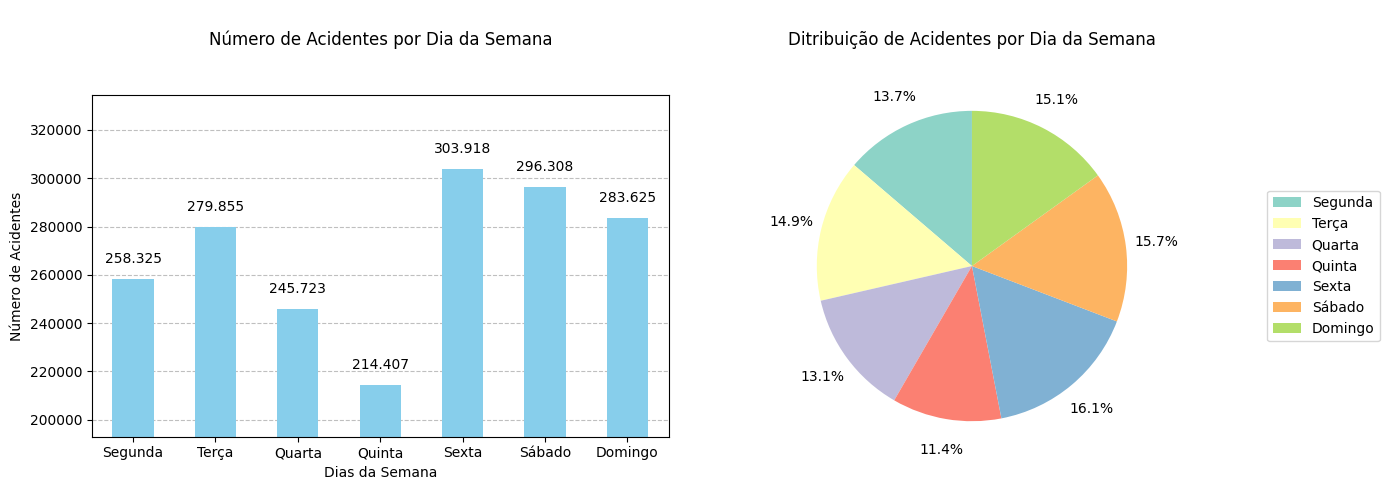

In [57]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
barras = acidentes_por_dia.plot(kind='bar', color='skyblue')
plt.xlabel("Dias da Semana")
plt.ylabel('Número de Acidentes')
plt.title('\nNúmero de Acidentes por Dia da Semana\n\n')
plt.xticks(rotation=0, ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.gca().set_axisbelow(True)
plt.ylim(min(acidentes_por_dia)*0.9, max(acidentes_por_dia) * 1.1)

for i, valor in enumerate(acidentes_por_dia):
    plt.text(i, valor + 0.1, formatar_milhar(str(valor))+'\n', ha='center')

plt.subplot(1, 2, 2)
plt.pie(acidentes_por_dia, autopct='%1.1f%%', pctdistance=1.2, startangle=90, colors=plt.cm.Set3.colors)
plt.title('\nDitribuição de Acidentes por Dia da Semana\n\n')
plt.legend(acidentes_por_dia.index, loc="center left", bbox_to_anchor=(1, 0.5))
plt.axis('equal')

plt.tight_layout()

plt.show()

In [58]:
acidentes_por_clima_media = acidentes_por_clima.mean(numeric_only=True)
acidentes_por_clima = acidentes_por_clima.size().sort_values()

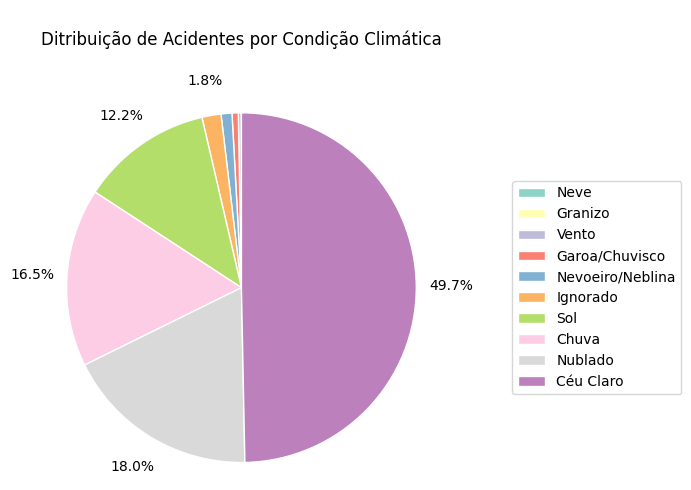

In [59]:
plt.figure(figsize=(7, 5))

autopct = lambda v: f'{v:.1f}%' if v > 1.5 else None

plt.pie(acidentes_por_clima,
        autopct=autopct,
        pctdistance=1.2,
        startangle=90,
        colors=plt.cm.Set3.colors,
        wedgeprops= {'linewidth': 1, 'edgecolor':'white'})

plt.title('\nDitribuição de Acidentes por Condição Climática\n\n')
plt.legend(acidentes_por_clima.index, loc="center left", bbox_to_anchor=(1.1,.5))
plt.axis('equal')

plt.tight_layout()
plt.show()

In [60]:
acidentes_por_clima_media = acidentes_por_clima_media[["mortos", "feridos_graves"]].sort_values(by="mortos", ascending=0)

In [61]:
acidentes_por_clima_media

,mortos,feridos_graves
condicao_metereologica,,
Neve,0.091743,0.165138
Ignorado,0.089455,0.242651
Nevoeiro/Neblina,0.084964,0.211748
Vento,0.076583,0.230754
Garoa/Chuvisco,0.064421,0.200718
Céu Claro,0.060482,0.196134
Nublado,0.052321,0.174156
Chuva,0.042954,0.139921
Sol,0.035619,0.154679


<Figure size 1000x600 with 0 Axes>

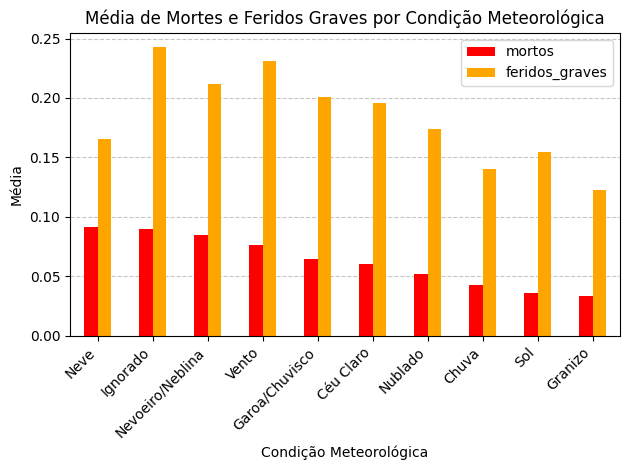

In [62]:
plt.figure(figsize=(10, 6))
acidentes_por_clima_media.plot(kind='bar', color=['red', 'orange'])
plt.title('Média de Mortes e Feridos Graves por Condição Meteorológica')
plt.xlabel('Condição Meteorológica')
plt.ylabel('Média')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.show()

In [63]:
acidentes_por_mes_ano = df.groupby([df['data_inversa'].dt.year, df['data_inversa'].dt.month]).size()
acidentes_por_mes_ano.index = pd.to_datetime(acidentes_por_mes_ano.index.map(lambda x: '-'.join(map(str, x))))

acidentes_por_ano = acidentes_por_ano.size()
acidentes_por_ano.index = pd.to_datetime(acidentes_por_ano.index.map(lambda x:f"{x}-01-01"))

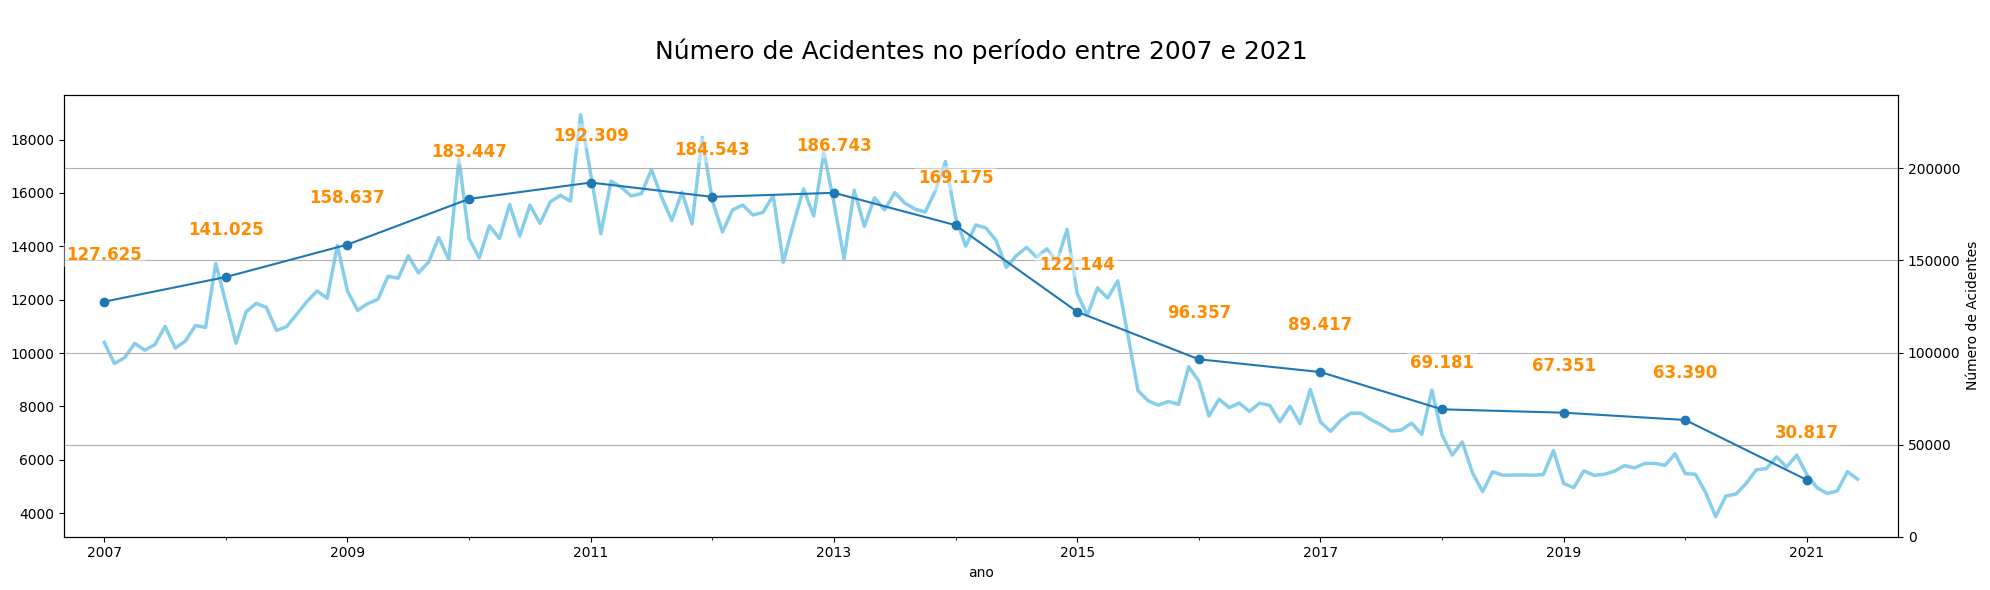

In [64]:
plt.figure(figsize=(20, 6))

acidentes_por_mes_ano.plot(color='skyblue', linestyle='-', linewidth=2.5)
acidentes_por_ano.plot(secondary_y=True, marker='o')

plt.xlabel('Mês e Ano')
plt.ylabel('Número de Acidentes')
plt.title('\nNúmero de Acidentes no período entre 2007 e 2021\n', size=18)
plt.grid(True)
plt.xticks(rotation=0)

limite_inferior = acidentes_por_mes_ano.index.min() - pd.DateOffset(months=4)
limite_superior = acidentes_por_mes_ano.index.max() + pd.DateOffset(months=4)
plt.xlim(limite_inferior, limite_superior)
plt.ylim(0, 240000)

media_anual_acidentes = acidentes_por_ano.groupby(acidentes_por_ano.index.year).mean()
media_anual_acidentes.index = pd.to_datetime(media_anual_acidentes.index, format='%Y')

for i, valor in enumerate(media_anual_acidentes):
    plt.annotate(formatar_milhar(str(int(valor))), (media_anual_acidentes.index[i], valor),
                 textcoords="offset points", xytext=(0, 30), ha='center', fontsize=12, fontweight='bold', color='darkorange',
                 bbox=dict(facecolor='white', alpha=0.4, edgecolor='none', boxstyle='round,pad=0.2')
                )

plt.tight_layout()
plt.show()

In [65]:
df["letal"] = df["mortos"] > 0

In [66]:
media_mortalidade_por_tipo = acidentes_por_tipo.mean(numeric_only=True)['mortos']
media_letalidade_por_tipo = acidentes_por_tipo.mean(numeric_only=True)['letal']

In [67]:
def quebrar_linha_labels(labels, comprimento_maximo=15):
    labels_quebrados = []
    for label in labels:
        if len(label) > comprimento_maximo:
            pos = label.rfind(' ', 0, comprimento_maximo)
            if pos != -1:
                labels_quebrados.append(label[:pos] + '\n' + label[pos+1:])
            else:
                labels_quebrados.append(label[:comprimento_maximo] + '\n' + label[comprimento_maximo:])
        else:
            labels_quebrados.append(label)
    return labels_quebrados

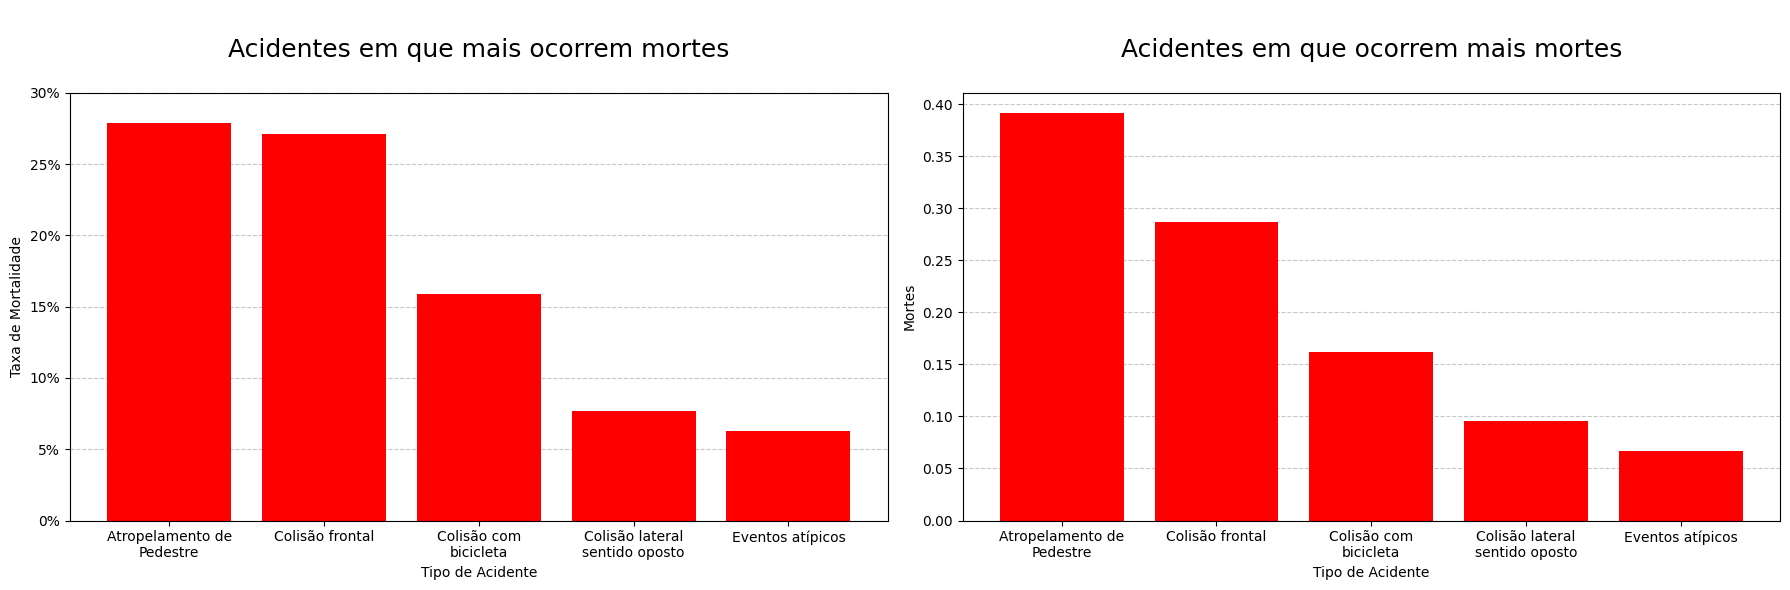

In [68]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def percent_formatter(x, pos):
    return '{:.0f}%'.format(x * 100)

formatter = ticker.FuncFormatter(percent_formatter)

media_letalidade_por_tipo = acidentes_por_tipo.mean(numeric_only=True)['letal']
top_5_letais = media_letalidade_por_tipo.sort_values(ascending=False).head(5)

media_mortalidade_por_tipo = acidentes_por_tipo.mean(numeric_only=True)['mortos']
top_5_mortais = media_mortalidade_por_tipo.sort_values(ascending=False).head(5)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

axs[0].bar(range(len(top_5_letais)), top_5_letais, color='red')
axs[0].set_title('\nAcidentes em que mais ocorrem mortes\n', size=18)
axs[0].set_xlabel('Tipo de Acidente')
axs[0].set_ylabel('Taxa de Mortalidade')
axs[0].set_ylim(0, 0.3)
axs[0].set_xticks(range(len(top_5_letais)))
axs[0].yaxis.set_major_formatter(formatter)
axs[0].set_xticklabels(quebrar_linha_labels(top_5_letais.index, 18), rotation=0, ha='center')
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
axs[0].set_axisbelow(True)

axs[1].bar(range(len(top_5_mortais)), top_5_mortais, color='red')
axs[1].set_title('\nAcidentes em que ocorrem mais mortes\n', size=18)
axs[1].set_xlabel('Tipo de Acidente')
axs[1].set_ylabel('Mortes')
axs[1].set_ylim(0, None)
axs[1].set_xticks(range(len(top_5_mortais)))
axs[1].set_xticklabels(quebrar_linha_labels(top_5_letais.index, 18), rotation=0, ha='center')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
axs[1].set_axisbelow(True)

plt.tight_layout()
plt.show()

In [69]:
media_acidentes_por_tracado = acidentes_por_tracado.mean(numeric_only=True).mortos.sort_values(ascending=0)

In [70]:
media_acidentes_por_tracado

tracado_via
Ponte                    0.121212
Desvio Temporário        0.096441
Não Informado            0.090998
Curva                    0.060903
Reta                     0.053918
Túnel                    0.032258
Retorno Regulamentado    0.029951
Interseção de vias       0.029585
Viaduto                  0.028559
Rotatória                0.021709
Cruzamento               0.016897
Name: mortos, dtype: float64

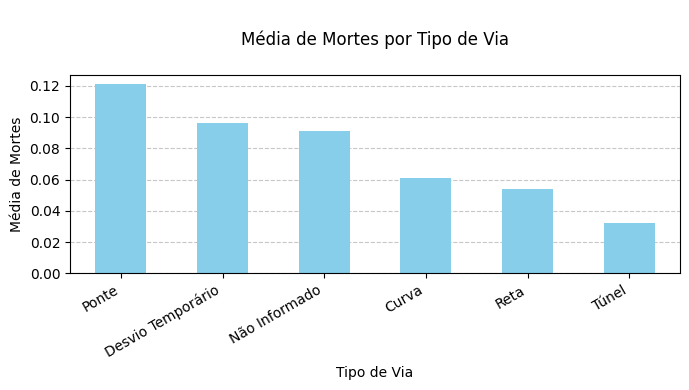

In [71]:
plt.figure(figsize=(7, 4))
media_acidentes_por_tracado[:6].plot(kind='bar', color='skyblue')

plt.title('\nMédia de Mortes por Tipo de Via\n')
plt.xlabel('Tipo de Via')
plt.ylabel('Média de Mortes')

plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().set_axisbelow(True)

plt.tight_layout()
plt.show()

In [72]:
acidentes_por_ano_br = acidentes_por_ano_br.size()
acidentes_por_ano_br = acidentes_por_ano_br.reset_index(name='num_acidentes')
br_mais_acidentes_por_ano = acidentes_por_ano_br.loc[acidentes_por_ano_br.groupby('ano')['num_acidentes'].idxmax()]

In [73]:
br_mais_acidentes_por_ano.to_csv("br_mais_acidentes_por_ano.csv")

In [74]:
cols = ['dia_semana','uf','fase_dia','tracado_via','br']

contagem_combinacoes = df[df["ano"] >= 2012].groupby(cols).size()

comb_com_mais_15_registros = contagem_combinacoes[contagem_combinacoes > 15].index


df_filtrado = df[df[cols].apply(tuple, axis=1).isin(comb_com_mais_15_registros)]

media_mortos_comb_filtradas = df_filtrado.groupby(cols)['letal'].mean()

media_mortos_comb_filtradas.sort_values(ascending=0)[:10]

dia_semana  uf  fase_dia     tracado_via        br 
Segunda     PI  Plena noite  Reta               407    0.517241
Sábado      PB  Plena noite  Reta               412    0.454545
Domingo     MA  Plena noite  Reta               226    0.450000
            CE  Plena noite  Não Informado      20     0.444444
            MA  Plena noite  Curva              222    0.437500
Sábado      CE  Plena noite  Reta               402    0.388889
Domingo     PE  Plena noite  Reta               110    0.387097
Sexta       PR  Plena noite  Desvio Temporário  376    0.375000
Domingo     PE  Anoitecer    Reta               316    0.370370
            MA  Pleno dia    Reta               226    0.351852
Name: letal, dtype: float64

In [75]:
maior_media_mortos = media_mortos_comb_filtradas.idxmax()
media_maior_mortos = media_mortos_comb_filtradas.max()

print("A combinação com a maior chance de morte (com mais de 30 registros):", maior_media_mortos)
print("Chance de mortos", media_maior_mortos)

A combinação com a maior chance de morte (com mais de 30 registros): ('Segunda', 'PI', 'Plena noite', 'Reta', 407)
Chance de mortos 0.5172413793103449


In [76]:
media_mortos_comb_filtradas

dia_semana  uf  fase_dia     tracado_via        br 
Domingo     AC  Anoitecer    Reta               364    0.050000
                Plena noite  Reta               364    0.083744
                Pleno dia    Curva              364    0.000000
                             Reta               317    0.090909
                                                364    0.047619
                                                         ...   
Terça       TO  Pleno dia    Desvio Temporário  153    0.100000
                             Não Informado      153    0.088889
                             Reta               153    0.079096
                                                226    0.082192
                                                242    0.100000
Name: letal, Length: 6939, dtype: float64

In [77]:
df

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,mes,letal
2,1032898,2007-08-13,Segunda,14:25:00,MG,40,585.5,ITABIRITO,Outras,Saída de Pista,...,3,0,0,1,2,0,1,1,8,False
3,1051130,2007-02-12,Segunda,02:10:00,MA,135,11,SAO LUIS,Animais na Pista,Atropelamento de Animal,...,5,2,2,1,0,0,3,1,2,True
4,1066824,2007-11-20,Terça,05:30:00,CE,222,30.8,CAUCAIA,Defeito mecânico em veículo,Capotamento,...,1,0,1,0,0,0,1,1,11,False
5,1069918,2007-12-16,Domingo,17:40:00,MA,230,14,BARAO DE GRAJAU,Outras,Capotamento,...,1,0,0,1,0,0,1,1,12,False
6,1070971,2007-03-05,Segunda,08:10:00,PR,277,584.4,CASCAVEL,Outras,Colisão lateral,...,2,0,0,0,2,0,0,2,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1882948,373974,2021-06-16,Quarta,13:15:00,BA,116,466,SANTO ESTEVAO,Condutor deixou de manter distância do veículo...,Colisão traseira,...,2,0,1,0,0,1,1,2,6,False
1882949,374024,2021-06-28,Segunda,10:50:00,PR,277,576,CASCAVEL,Velocidade Incompatível,Engavetamento,...,8,0,2,0,6,0,2,5,6,False
1882950,374224,2021-06-13,Domingo,02:50:00,SP,116,"102,7",PINDAMONHANGABA,Reação tardia ou ineficiente do condutor,Colisão traseira,...,2,0,1,0,0,1,1,2,6,False
1882951,374239,2021-06-02,Quarta,08:45:00,RN,101,85,NATAL,Velocidade Incompatível,Colisão traseira,...,2,0,0,1,1,0,1,2,6,False
